In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd 
import seaborn as sns 
from xgboost.sklearn import XGBClassifier
import numpy as np
import math
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt 

In [ ]:
import os 
os.environ["KAGGLE_USERNAME"]="daominhkhanh"
os.environ["KAGGLE_KEY"]="90e6f266906e9dcfeae1afea9a0630ac"
!kaggle competitions download -c airbnb-recruiting-new-user-bookings

 56% 33.0M/59.1M [00:00<00:00, 130MB/s]
100% 59.1M/59.1M [00:00<00:00, 149MB/s]
  0% 0.00/478k [00:00<?, ?B/s]
100% 478k/478k [00:00<00:00, 139MB/s]
  0% 0.00/1.03M [00:00<?, ?B/s]
100% 1.03M/1.03M [00:00<00:00, 147MB/s]
  0% 0.00/546 [00:00<?, ?B/s]
100% 546/546 [00:00<00:00, 306kB/s]
  0% 0.00/2.46k [00:00<?, ?B/s]
100% 2.46k/2.46k [00:00<00:00, 2.17MB/s]
  0% 0.00/4.07M [00:00<?, ?B/s]
100% 4.07M/4.07M [00:00<00:00, 135MB/s]


In [ ]:
train1=pd.read_csv('train_avg_age.csv')
test1=pd.read_csv('test_avg_age.csv')
val1=pd.read_csv('val_avg_age.csv')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


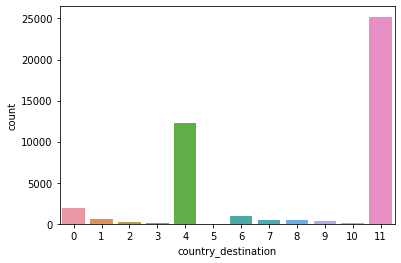

In [ ]:
sns.countplot(val1.country_destination)

In [ ]:
train2=pd.read_csv('train_knn_age.csv')
test2=pd.read_csv('test_knn_age.csv')
val2=pd.read_csv('val_knn_age.csv')

In [ ]:
def ndcg(index):
  return 1/math.log2(index+2)

def cal_ndcg(preds,labels):
  size=len(labels)
  ndcg_score=0
  for i in range(size):
    index=np.where(preds[i,:]==labels[i])[0]
    if len(index)==0:
      continue
    index=index[0]
    ndcg_score+=ndcg(index)
  return ndcg_score/size

In [ ]:
id_test=test1.id
test1.drop('id',axis=1,inplace=True)
test2.drop('id',axis=1,inplace=True)

In [ ]:
def get_value(data_train,data_test,data_val):
  y_train=data_train.country_destination.values
  y_val=data_val.country_destination.values
  data_val.drop('country_destination',axis=1,inplace=True)
  data_train.drop('country_destination',axis=1,inplace=True)
  x_train=data_train.values
  x_test=data_test.values
  x_val=data_val.values
  return x_train,y_train,x_val,y_val,x_test

In [ ]:
country={'AU': 3, 'CA': 9, 'DE': 2, 'ES': 8, 'FR': 6, 'GB': 7, 'IT': 1, 'NDF': 11, 'NL': 10, 'PT': 5, 'US': 4, 'other': 0}
int_to_country={value:con for con,value in country.items()}

In [ ]:
x_train1,y_train1,x_val1,y_val1,x_test1=get_value(train1.copy(),test1.copy(),val1.copy())
x_train2,y_train2,x_val2,y_val2,x_test2=get_value(train2.copy(),test2.copy(),val2.copy())

# Tuning learning rate for xgboost

In [ ]:
lr=[0.005,0.01,0.05,0.1,0.15,0.2]
n_estimators=[25,50,75,100,125]

In [ ]:
def submit(model,x_test,file_name):
  ids=[]
  cts=[]
  y_preds=model.predict_proba(x_test)
  for i in range(len(x_test)):
    idx=id_test[i]
    ids+=[idx]*5
    temp=np.argsort(y_preds[i])[::-1][:5].tolist()
    for value in temp:
      cts.append(int_to_country[value])
  sub=pd.DataFrame(np.column_stack((ids,cts)),columns=['id','country'])
  sub.to_csv(file_name,index=False)

In [ ]:
def tuning_param(x_train,y_train,x_val,y_val,x_test,learn_rate,file_name):
  xgb=XGBClassifier(max_depth=10,learning_rate=learn_rate,n_entimators=100,objective='multi:softprob',subsample=0.5,colsample_bytree=0.5,seed=43)
  xgb.fit(x_train,y_train)
  y_preds1=xgb.predict_proba(x_val)
  preds_down=np.argsort(y_preds1,axis=1)[:,-5:]
  preds_down=np.fliplr(preds_down)
  score=cal_ndcg(preds_down,y_val)
  submit(xgb,x_test,file_name+"_lr_"+str(learn_rate)+'.csv')
  return score

In [ ]:
def tuning(x_train,y_train,x_val,y_val,x_test,file_name):
  scores_his=[]
  for value in lr:
    score=tuning_param(x_train,y_train,x_val,y_val,x_test,value,file_name)
    scores_his.append(score)
    print(score)
    
  plt.plot(lr,scores_his)
  plt.xlabel('lr')
  plt.ylabel('score')
  plt.savefig(f'{file_name}.png')
  plt.show()

0.8232738249987241
0.8251862205951613
0.8283418920002229
0.8278229305993968
0.8271431257944282
0.8256797083292625


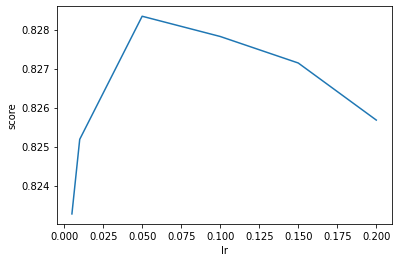

In [ ]:
tuning(x_train1,y_train1,x_val1,y_val1,x_test1,'avg')

0.8188990363822678
0.821217115172219
0.8240916631648533
0.8243537237978218
0.8232612621806381
0.8215124119681628


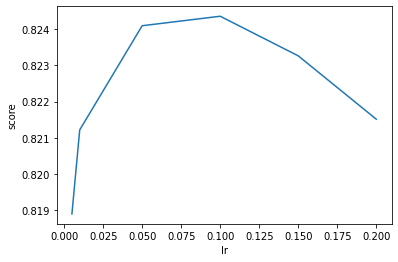

In [ ]:
tuning(x_train2,y_train2,x_val2,y_val2,x_test2,'knn')

In [ ]:
def tuning_param_es(x_train,y_train,x_val,y_val,x_test,n_es,file_name):
  xgb=XGBClassifier(max_depth=10,learning_rate=0.05,n_entimators=n_es,objective='multi:softprob',subsample=0.5,colsample_bytree=0.5,seed=43)
  xgb.fit(x_train,y_train)
  y_preds1=xgb.predict_proba(x_val)
  preds_down=np.argsort(y_preds1,axis=1)[:,-5:]
  preds_down=np.fliplr(preds_down)
  score=cal_ndcg(preds_down,y_val)
  submit(xgb,x_test,file_name+"_lr_"+str(n_es)+'.csv')
  return score

In [ ]:
def tuning_es(x_train,y_train,x_val,y_val,x_test,file_name):
  scores_his=[]
  for value in n_estimators:
    score=tuning_param_es(x_train,y_train,x_val,y_val,x_test,value,file_name)
    scores_his.append(score)
    print(score)

  plt.plot(n_estimators,scores_his)
  plt.xlabel('n_entimators')
  plt.ylabel('score')
  plt.savefig(f'{file_name}.png')
  plt.show()

0.8283418920002229
0.8283418920002229
0.8283418920002229
0.8283418920002229
0.8283418920002229


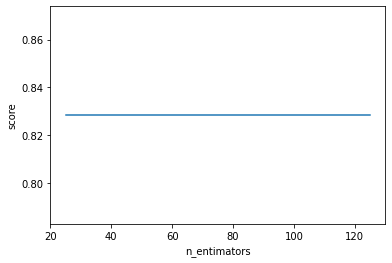

In [ ]:
tuning_es(x_train1,y_train1,x_val1,y_val1,x_test1,'avg_es')

0.8240916631648533
0.8240916631648533
0.8240916631648533
0.8240916631648533
0.8240916631648533


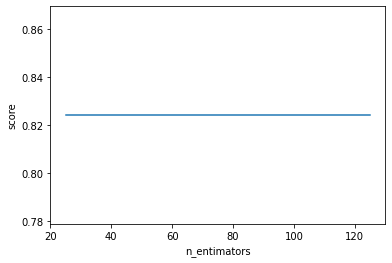

In [ ]:
tuning_es(x_train2,y_train2,x_val2,y_val2,x_test2,'knn_es')

# Neural Network

In [ ]:
import torch 
from torch import nn 
from torch import optim

In [ ]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_chain = nn.Sequential(
            nn.Linear(13, 512),
            nn.ReLU(),
            nn.LayerNorm(512),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.LayerNorm(256),
            nn.Linear(256, 12),
        )
    def forward(self, x):
        result = self.linear_chain(x)
        return result


In [ ]:
def convert_datatype(x_train,y_train,x_val,y_val,x_test):
  x_train=torch.from_numpy(x_train.astype(np.float32)).to(device)
  y_train=torch.from_numpy(y_train).to(device)
  x_val=torch.from_numpy(x_val.astype(np.float32)).to(device)
  y_val=torch.from_numpy(y_val).to(device)
  x_test=torch.from_numpy(x_test.astype(np.float32)).to(device)
  return x_train,y_train,x_val,y_val,x_test

In [ ]:
x_train1,y_train1,x_val1,y_val1,x_test1=convert_datatype(x_train1,y_train1,x_val1,y_val1,x_test1)

In [ ]:
x_train2,y_train2,x_val1,y_val2,x_test2=convert_datatype(x_train2,y_train2,x_val2,y_val2,x_test2)

In [ ]:
def submmit_ann(model,x_test,file_name):
  with torch.no_grad():
    model.eval()
    preds=model(x_test)
    preds=torch.argsort(preds,dim=1,descending=True)[:,:5].cpu().numpy()
    idxs=[]
    cts=[]
    for i in range(len(test1)):
      idxs+=[id_test[i]]*5
      for value in preds[i]:
        cts.append(int_to_country[value])
    sub=pd.DataFrame(np.column_stack((idxs,cts)),columns=['id','country'])
    sub.to_csv(file_name,index=False)


In [ ]:
def train(model_ann,optimizer,x_train,y_train,x_val,y_val,x_test,file_name):
  ndg_score=[]
  cnt=0
  for epoch in range(n_epochs):
    model_ann.train()
    output=model_ann(x_train)
    loss=criterion(output,y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch!=0 and epoch%3==0:
      model_ann.eval()
      preds=model_ann(x_val)
      temp=torch.argmax(preds,dim=1)
      accuracy=accuracy_score(y_val1.cpu().numpy(),temp.cpu().numpy())
      preds1=torch.argsort(preds,dim=1,descending=True)[:,:5]
      preds1=preds1.cpu().detach().numpy()
      score=cal_ndcg(preds1,y_val.cpu().numpy())
      cnt+=1
      ndg_score.append(score)
      print(f"Epoch:{epoch}----loss:{loss.item()}---val_acc:{accuracy}---NDCG_score:{score}")
  plt.plot(range(cnt),ndg_score)
  plt.savefig('ann_score.png')
  submmit_ann(model_ann,x_test,file_name+'.csv')


In [ ]:
def train1(model_ann,optimizer,x_train,y_train,x_val,y_val,x_test,n_epochs):
  for epoch in range(n_epochs):
    model_ann.train()
    output=model_ann(x_train)
    loss=criterion(output,y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch%100==0:
      print(f"Epoch:{epoch}---loss:{loss.item()}")
    
  with torch.no_grad():
    model_ann.eval()
    preds=model_ann(x_val)
    preds1=torch.argsort(preds,dim=1,descending=True)[:,:5]
    preds1=preds1.cpu().detach().numpy()
    score=cal_ndcg(preds1,y_val.cpu().numpy())
  return score

Epoch:0---loss:2.253161907196045
Epoch:100---loss:1.160406470298767
Epoch:200---loss:1.1548107862472534
Epoch:300---loss:1.151299238204956
Epoch:400---loss:1.1484657526016235
Epoch:500---loss:1.1460431814193726
Epoch:600---loss:1.1439063549041748
Epoch:700---loss:1.1419291496276855
Epoch:800---loss:1.1400669813156128
Epoch:900---loss:1.1383336782455444
Epoch:1000---loss:1.152628779411316
Epoch:1100---loss:1.1416350603103638
Epoch:1200---loss:1.140120029449463
Epoch:1300---loss:1.1396123170852661
Epoch:1400---loss:1.1388921737670898
Epoch:1500---loss:1.1383389234542847
Epoch:1600---loss:1.1375164985656738
Epoch:1700---loss:1.1371225118637085
Epoch:1800---loss:1.1365350484848022
Epoch:1900---loss:1.1360591650009155
Epoch:0---loss:2.3616154193878174
Epoch:100---loss:1.1555036306381226
Epoch:200---loss:1.150324821472168
Epoch:300---loss:1.150895357131958
Epoch:400---loss:1.1510852575302124
Epoch:500---loss:1.1498628854751587
Epoch:600---loss:1.1488149166107178
Epoch:700---loss:1.1475601196

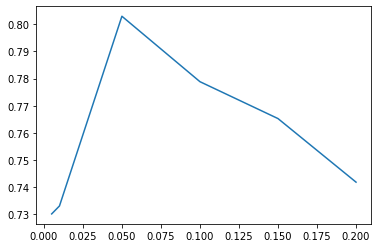

In [ ]:
score_list=[]
lr_list=[0.005,0.01,0.05,0.1,0.15,0.2]
for lr_value in lr_list:
  model=NeuralNetwork().to(device)
  criterion=nn.CrossEntropyLoss()
  n_epochs=2000
  optimizer=optim.SGD(model.parameters(),lr=lr_value)
  score=train1(model,optimizer,x_train1,y_train1,x_val1,y_val1,x_test1,n_epochs)
  score_list.append(score)
plt.plot(lr_list,score_list)
plt.savefig('ann_tuning.png')

In [ ]:
!kaggle competitions submit airbnb-recruiting-new-user-bookings -f submmit_ann_avg.csv -m "Yeah! I submit my file through the Google Colab!"

In [ ]:
train(x_train2,y_train2,x_val1,y_val2,x_test2,'submmit_ann_knn')